## Index fund - Investing strategies

In [439]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math

In [440]:
# Creating basket with 2 index fund - nifty & banknifty
nifty_bees = yf.Ticker("NIFTYBEES.NS")
bank_bees = yf.Ticker("BANKBEES.NS")

In [441]:
# get info
#print(nifty_bees.info)

# get historical market data
days = '450d' #450 days timeframe is considered for analysis
nbees = nifty_bees.history(period=days)
bbees = bank_bees.history(period=days)
nbees.shape, bbees.shape

((449, 7), (449, 7))

In [442]:
nbees.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-15,131.399994,131.449997,130.000000,131.009995,318992,0,0
2020-01-16,131.449997,131.500000,130.000000,130.910004,277915,0,0
2020-01-17,131.449997,131.449997,130.500000,131.190002,394076,0,0
2020-01-20,131.210007,131.500000,129.699997,129.779999,769381,0,0
2020-01-21,130.350006,130.350006,129.050003,129.270004,458654,0,0


In [443]:
nbees.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-10-29,209.000000,209.000000,182.100006,191.160004,3221676,0,0
2021-11-01,208.880005,208.880005,191.360001,193.839996,1708376,0,0
2021-11-02,206.899994,206.899994,183.600006,193.100006,1283566,0,0
2021-11-03,200.000000,200.000000,190.100006,192.580002,955400,0,0
2021-11-04,207.880005,207.880005,185.110001,193.589996,671760,0,0


<AxesSubplot:xlabel='Date'>

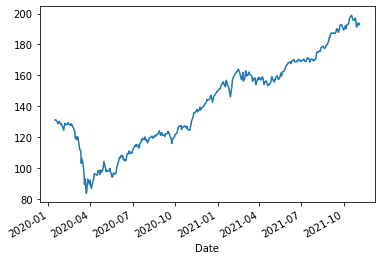

In [444]:
nbees.Close.plot()

<AxesSubplot:xlabel='Date'>

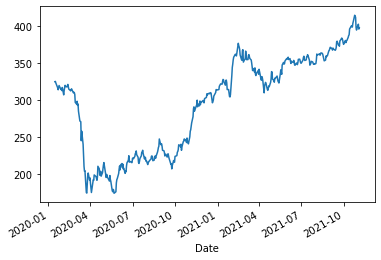

In [445]:
bbees.Close.plot()

In [446]:
# Create basket for analysing investing strategies
basket = nbees.merge(bbees[['Close','Volume']],left_index=True,right_index=True)
basket.shape

(449, 9)

In [447]:
# Drop unwanted columns
basket.drop(['Open','High','Low','Dividends','Stock Splits'],axis=1,inplace=True)
basket.head()

,Close_x,Volume_x,Close_y,Volume_y
Date,,,,
2020-01-15,131.009995,318992,324.799988,89742
2020-01-16,130.910004,277915,325.160004,85986
2020-01-17,131.190002,394076,322.910004,163727
2020-01-20,129.779999,769381,318.000000,171089
2020-01-21,129.270004,458654,316.420013,85599


In [448]:
# Calculate basket price and volume for analysis
basket['price'] = basket['Close_x'] + basket['Close_y']
basket['volume'] = basket['Volume_x'] + basket['Volume_y']
basket.head()

,Close_x,Volume_x,Close_y,Volume_y,price,volume
Date,,,,,,
2020-01-15,131.009995,318992,324.799988,89742,455.809982,408734
2020-01-16,130.910004,277915,325.160004,85986,456.070007,363901
2020-01-17,131.190002,394076,322.910004,163727,454.100006,557803
2020-01-20,129.779999,769381,318.000000,171089,447.779999,940470
2020-01-21,129.270004,458654,316.420013,85599,445.690018,544253


In [449]:
# Creating features for analysis

basket['month'] = basket.reset_index()['Date'].dt.month.values
basket['week_no'] = basket.reset_index()['Date'].dt.isocalendar()['week'].values
basket['weekday'] = basket.reset_index()['Date'].dt.isocalendar()['day'].values
basket['year'] = basket.reset_index()['Date'].dt.year.values
basket['month_yr'] = basket['month'].astype(str) + '_' + basket['year'].astype(str)
basket.drop(['Close_x','Volume_x','Close_y','Volume_y'],axis=1,inplace=True)
basket.head()

,price,volume,month,week_no,weekday,year,month_yr
Date,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020
2020-01-16,456.070007,363901,1,3,4,2020,1_2020
2020-01-17,454.100006,557803,1,3,5,2020,1_2020
2020-01-20,447.779999,940470,1,4,1,2020,1_2020
2020-01-21,445.690018,544253,1,4,2,2020,1_2020


<AxesSubplot:xlabel='Date'>

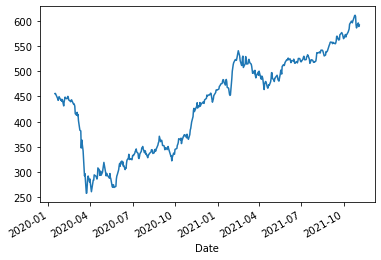

In [450]:
basket.price.plot()

<AxesSubplot:xlabel='price'>

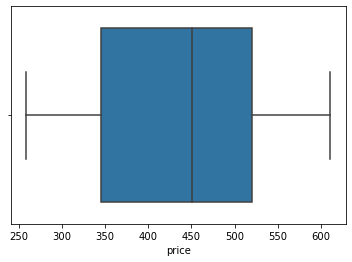

In [451]:
sns.boxplot(x=basket.price)

### Investing strategies

The investing strategies are analysed based on:
1. Buying constant units - weekly
2. Buying constant units - monthly
3. Invest with constant amount - weekly
4. Invest with constant amount - monthly
5. Double invest amount during dips - weekly
6. Double invest amount during dips - monthly

In [452]:
# Create dictionary to append all strategy values for comparison
basket_strat = dict()

In [453]:
def strategy_calc(data):
    
    df = data.copy()
    df['invest_units'] = df['buy_units'].cumsum()
    df['invest_price'] = df['buy_price'].cumsum()
    df['MTM'] = df['invest_units'] * df['price']
    df['profit_loss'] = df['MTM'] - df['invest_price']
    
    plt.figure(figsize=(8,6))
    df['profit_loss'].plot(title='Strategy - Profit/Loss trend')
    
    return df

In [454]:
def strategy_results(data):
    
    df = data.copy()
    total_invested = round(df['invest_price'][-1],2)
    net_profit_loss = round(df['profit_loss'][-1],2)
    units_bought = df['invest_units'][-1]
    max_mtm = round(df['profit_loss'].max(),2)
    min_mtm = round(df['profit_loss'].min(),2)
    avg_mnth_invest = round(df.groupby('month_yr')['buy_price'].sum().mean(),2)
    abs_returns = round(net_profit_loss/total_invested,2)*100

    print(f"Total units invested - {units_bought} units")
    print(f"Total amount invested - Rs.{total_invested}")
    print(f"Avg monthly investment - Rs.{avg_mnth_invest}")
    print(f"Net absolute returns - {abs_returns}%")
    print(f"Range of Basket P/L - Rs.{min_mtm} - Rs.{max_mtm}")
    
    return df,[units_bought,total_invested,avg_mnth_invest,abs_returns,min_mtm,max_mtm]

### Strategy 1 - Invest constant units every week

In [455]:
basket1 = basket.copy()
n_units = 2

In [456]:
basket1['buy'] = np.where(basket1['week_no'].shift(1).bfill() != basket1['week_no'],1,0)
basket1.head()

,price,volume,month,week_no,weekday,year,month_yr,buy
Date,,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020,0
2020-01-16,456.070007,363901,1,3,4,2020,1_2020,0
2020-01-17,454.100006,557803,1,3,5,2020,1_2020,0
2020-01-20,447.779999,940470,1,4,1,2020,1_2020,1
2020-01-21,445.690018,544253,1,4,2,2020,1_2020,0


In [457]:
basket1['buy_units'] = basket1['buy'] * n_units
basket1['buy_price'] = basket1['buy_units'] * basket1['price']

basket1.head()

,price,volume,month,week_no,weekday,year,month_yr,buy,buy_units,buy_price
Date,,,,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020,0,0,0.000000
2020-01-16,456.070007,363901,1,3,4,2020,1_2020,0,0,0.000000
2020-01-17,454.100006,557803,1,3,5,2020,1_2020,0,0,0.000000
2020-01-20,447.779999,940470,1,4,1,2020,1_2020,1,2,895.559998
2020-01-21,445.690018,544253,1,4,2,2020,1_2020,0,0,0.000000


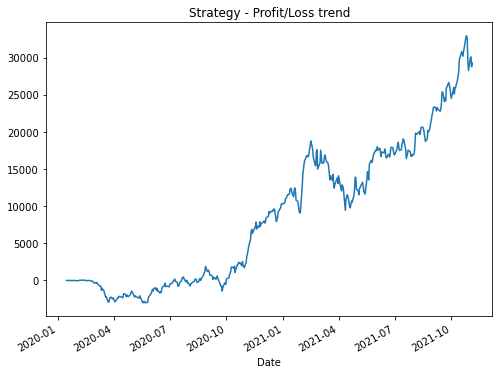

In [458]:
basket1 = strategy_calc(basket1)

In [459]:
basket1, values = strategy_results(basket1)

Total units invested - 188 units
Total amount invested - Rs.81881.48
Avg monthly investment - Rs.3560.06
Net absolute returns - 36.0%
Range of Basket P/L - Rs.-3011.62 - Rs.32926.26


In [460]:
strat = 'Buy_2units_weekly'
metrics = ['units_invested','total_amount','avg_month_invest','abs_returns','min_pl','max_pl']
basket_strat[strat] = dict(zip(metrics,values))

### Strategy 2 - Invest constant units every month

In [461]:
basket2 = basket.copy()
n_units = 10

In [462]:
basket2['buy'] = np.where(basket2['month'].shift(1).bfill() != basket2['month'],1,0)
basket2.head()

,price,volume,month,week_no,weekday,year,month_yr,buy
Date,,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020,0
2020-01-16,456.070007,363901,1,3,4,2020,1_2020,0
2020-01-17,454.100006,557803,1,3,5,2020,1_2020,0
2020-01-20,447.779999,940470,1,4,1,2020,1_2020,0
2020-01-21,445.690018,544253,1,4,2,2020,1_2020,0


In [463]:
basket2['buy_units'] = basket2['buy'] * n_units
basket2['buy_price'] = basket2['buy_units'] * basket2['price']

basket2.head()

,price,volume,month,week_no,weekday,year,month_yr,buy,buy_units,buy_price
Date,,,,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020,0,0,0.0
2020-01-16,456.070007,363901,1,3,4,2020,1_2020,0,0,0.0
2020-01-17,454.100006,557803,1,3,5,2020,1_2020,0,0,0.0
2020-01-20,447.779999,940470,1,4,1,2020,1_2020,0,0,0.0
2020-01-21,445.690018,544253,1,4,2,2020,1_2020,0,0,0.0


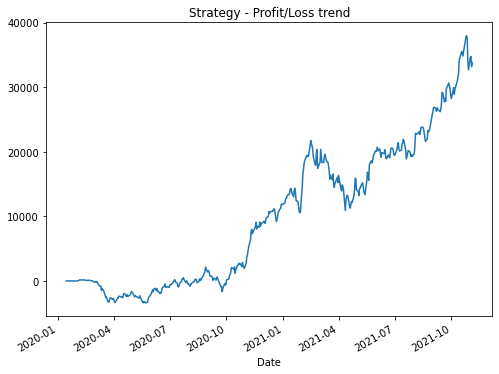

In [464]:
basket2 = strategy_calc(basket2)

In [465]:
basket2, values = strategy_results(basket2)

Total units invested - 220 units
Total amount invested - Rs.96252.5
Avg monthly investment - Rs.4184.89
Net absolute returns - 35.0%
Range of Basket P/L - Rs.-3390.8 - Rs.37974.2


In [466]:
strat = 'Buy_10units_monthly'
metrics = ['units_invested','total_amount','avg_month_invest','abs_returns','min_pl','max_pl']
basket_strat[strat] = dict(zip(metrics,values))

### Strategy 3 - Invest constant amount every week

In [467]:
basket3 = basket.copy()
week_amount = 1500.0

In [468]:
basket3['buy'] = np.where(basket3['week_no'].shift(1).bfill() != basket3['week_no'],1,0)
basket3.head()

,price,volume,month,week_no,weekday,year,month_yr,buy
Date,,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020,0
2020-01-16,456.070007,363901,1,3,4,2020,1_2020,0
2020-01-17,454.100006,557803,1,3,5,2020,1_2020,0
2020-01-20,447.779999,940470,1,4,1,2020,1_2020,1
2020-01-21,445.690018,544253,1,4,2,2020,1_2020,0


In [469]:
basket3['units'] = basket3['price'].apply(lambda x: math.floor(week_amount/x))
basket3['buy_units'] = basket3['buy'] * basket3['units']
basket3['buy_price'] = (basket3['buy_units'] * basket3['price']).round(2)

basket3.head()

,price,volume,month,week_no,weekday,year,month_yr,buy,units,buy_units,buy_price
Date,,,,,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020,0,3,0,0.00
2020-01-16,456.070007,363901,1,3,4,2020,1_2020,0,3,0,0.00
2020-01-17,454.100006,557803,1,3,5,2020,1_2020,0,3,0,0.00
2020-01-20,447.779999,940470,1,4,1,2020,1_2020,1,3,3,1343.34
2020-01-21,445.690018,544253,1,4,2,2020,1_2020,0,3,0,0.00


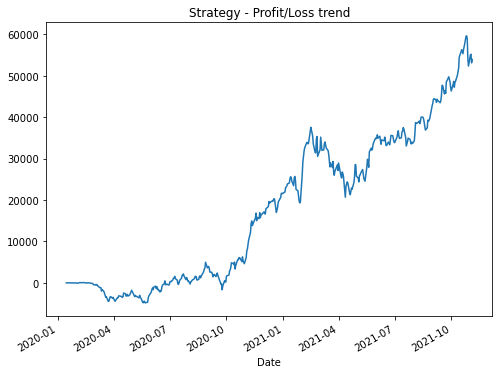

In [470]:
basket3 = strategy_calc(basket3)

In [471]:
basket3, values = strategy_results(basket3)

Total units invested - 294 units
Total amount invested - Rs.119901.87
Avg monthly investment - Rs.5213.12
Net absolute returns - 45.0%
Range of Basket P/L - Rs.-4826.64 - Rs.59655.97


In [472]:
strat = f'Buy_rs{week_amount}_weekly'
metrics = ['units_invested','total_amount','avg_month_invest','abs_returns','min_pl','max_pl']
basket_strat[strat] = dict(zip(metrics,values))

### Strategy 4 - Invest constant amount every month

In [473]:
basket4 = basket.copy()
month_amount = 5000.0

In [474]:
basket4['buy'] = np.where(basket4['month'].shift(1).bfill() != basket4['month'],1,0)
basket4.head()

,price,volume,month,week_no,weekday,year,month_yr,buy
Date,,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020,0
2020-01-16,456.070007,363901,1,3,4,2020,1_2020,0
2020-01-17,454.100006,557803,1,3,5,2020,1_2020,0
2020-01-20,447.779999,940470,1,4,1,2020,1_2020,0
2020-01-21,445.690018,544253,1,4,2,2020,1_2020,0


In [475]:
basket4['units'] = basket4['price'].apply(lambda x: math.floor(month_amount/x))
basket4['buy_units'] = basket4['buy'] * basket4['units']
basket4['buy_price'] = (basket4['buy_units'] * basket4['price']).round(2)

basket4.head()

,price,volume,month,week_no,weekday,year,month_yr,buy,units,buy_units,buy_price
Date,,,,,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020,0,10,0,0.0
2020-01-16,456.070007,363901,1,3,4,2020,1_2020,0,10,0,0.0
2020-01-17,454.100006,557803,1,3,5,2020,1_2020,0,11,0,0.0
2020-01-20,447.779999,940470,1,4,1,2020,1_2020,0,11,0,0.0
2020-01-21,445.690018,544253,1,4,2,2020,1_2020,0,11,0,0.0


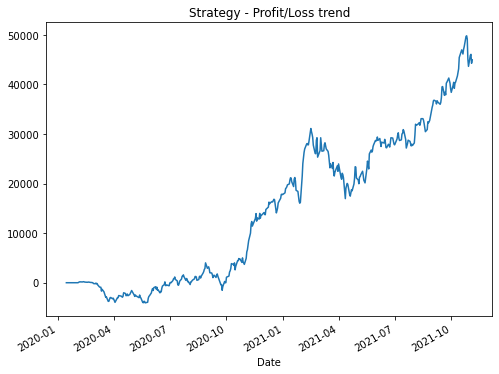

In [476]:
basket4 = strategy_calc(basket4)

In [477]:
basket4, values = strategy_results(basket4)

Total units invested - 254 units
Total amount invested - Rs.105227.13
Avg monthly investment - Rs.4575.09
Net absolute returns - 43.0%
Range of Basket P/L - Rs.-4059.0 - Rs.49800.53


In [478]:
strat = f'Buy_rs{month_amount}_monthly'
metrics = ['units_invested','total_amount','avg_month_invest','abs_returns','min_pl','max_pl']
basket_strat[strat] = dict(zip(metrics,values))

### Strategy 5 - Double the amount during dips weekly

In [479]:
basket5 = basket.copy()
basket5.reset_index(inplace=True)

In [480]:
basket5.price.mean()

437.3386642693942

In [481]:
dip_quantile = 0.50
n_rows = 31
time_frame = n_rows - 1
week_amount = 1500.0
multiplier = 3
limited_window = False
amt_constant = False
n_units = 3

To classify the price is low,say the set quantile value is 25%, then the 25% quantile is calculated at every day since first day of the analysis. If the price is trading lower than the set quantile value, then the index is considered as low, and double up the investment amount. If it is higher than set quantile value, then it invests fixed amount.

In [482]:
for r in range(n_rows,len(basket5)):
    price_val = basket5.loc[r,'price']
    if limited_window:
        dip_value = basket5.iloc[r-time_frame:r,:]['price'].quantile(dip_quantile)
    else:
        dip_value = basket5.iloc[:r,:]['price'].quantile(dip_quantile)
    if price_val < dip_value:
        dips = 1
    else:
        dips = 0
        
    basket5.loc[r,'dips'] = dips

In [483]:
basket5.fillna(0,inplace=True)
basket5.set_index('Date',inplace=True)
basket5.groupby('dips')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
dips,,,,,,,,
0.0,377.0,461.493688,80.579457,312.289993,374.260002,478.810013,522.570007,610.850006
1.0,72.0,310.860278,39.715907,258.299995,287.955004,297.345001,323.307505,418.669991


In [484]:
basket5['buy'] = np.where(basket5['week_no'].shift(1).bfill() != basket5['week_no'],1,0)
basket5.head()

,price,volume,month,week_no,weekday,year,month_yr,dips,buy
Date,,,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020,0.0,0
2020-01-16,456.070007,363901,1,3,4,2020,1_2020,0.0,0
2020-01-17,454.100006,557803,1,3,5,2020,1_2020,0.0,0
2020-01-20,447.779999,940470,1,4,1,2020,1_2020,0.0,1
2020-01-21,445.690018,544253,1,4,2,2020,1_2020,0.0,0


In [485]:
if amt_constant:
    basket5['units'] = basket5['price'].apply(lambda x: math.floor(week_amount/x))
else:
    basket5['units'] = n_units
    
basket5['buy_units'] = basket5['buy'] * basket5['units']
basket5['buy_units'] = np.where(basket5['dips'] == 1,basket5['buy_units']*multiplier,basket5['buy_units'])
basket5['buy_price'] = (basket5['buy_units'] * basket5['price']).round(2)

basket5.head()

,price,volume,month,week_no,weekday,year,month_yr,dips,buy,units,buy_units,buy_price
Date,,,,,,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020,0.0,0,3,0,0.00
2020-01-16,456.070007,363901,1,3,4,2020,1_2020,0.0,0,3,0,0.00
2020-01-17,454.100006,557803,1,3,5,2020,1_2020,0.0,0,3,0,0.00
2020-01-20,447.779999,940470,1,4,1,2020,1_2020,0.0,1,3,3,1343.34
2020-01-21,445.690018,544253,1,4,2,2020,1_2020,0.0,0,3,0,0.00


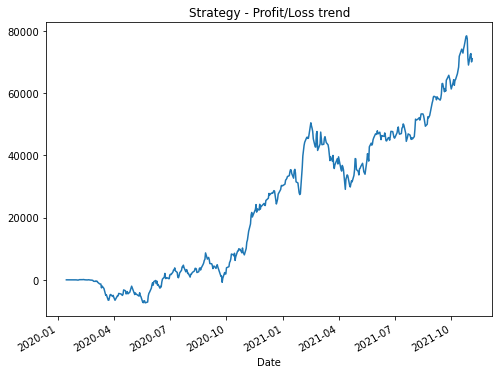

In [486]:
basket5 = strategy_calc(basket5)

In [487]:
basket5, values = strategy_results(basket5)

Total units invested - 378 units
Total amount invested - Rs.152434.74
Avg monthly investment - Rs.6627.6
Net absolute returns - 47.0%
Range of Basket P/L - Rs.-7395.99 - Rs.78418.47


In [488]:
strat = 'double_dips_weekly'
metrics = ['units_invested','total_amount','avg_month_invest','abs_returns','min_pl','max_pl']
basket_strat[strat] = dict(zip(metrics,values))

### Strategy 6 - Double the amount during dips weekly

In [489]:
basket6 = basket.copy()
basket6.reset_index(inplace=True)

In [490]:
dip_quantile = 0.5
n_rows = 31
amount = 5000.0
multiplier = 3.0

To classify the price is low,say the set quantile value is 25%, then the 25% quantile is calculated at every day since first day of the analysis. If the price is trading lower than the set quantile value, then the index is considered as low, and double up the investment amount. If it is higher than set quantile value, then it invests fixed amount.

In [491]:
for r in range(n_rows,len(basket6)):
    price_val = basket6.loc[r,'price']
    dip_value = basket6.iloc[:r,:]['price'].quantile(dip_quantile)
    if price_val < dip_value:
        dips = 1
    else:
        dips = 0
        
    basket6.loc[r,'dips'] = dips

In [492]:
basket6.fillna(0,inplace=True)
basket6.set_index('Date',inplace=True)
basket6.groupby('dips')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
dips,,,,,,,,
0.0,377.0,461.493688,80.579457,312.289993,374.260002,478.810013,522.570007,610.850006
1.0,72.0,310.860278,39.715907,258.299995,287.955004,297.345001,323.307505,418.669991


In [493]:
basket6['buy'] = np.where(basket6['month'].shift(1).bfill() != basket6['month'],1,0)
basket6.head()

,price,volume,month,week_no,weekday,year,month_yr,dips,buy
Date,,,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020,0.0,0
2020-01-16,456.070007,363901,1,3,4,2020,1_2020,0.0,0
2020-01-17,454.100006,557803,1,3,5,2020,1_2020,0.0,0
2020-01-20,447.779999,940470,1,4,1,2020,1_2020,0.0,0
2020-01-21,445.690018,544253,1,4,2,2020,1_2020,0.0,0


In [494]:
basket6['units'] = basket6['price'].apply(lambda x: math.floor(amount/x))
basket6['buy_units'] = basket6['buy'] * basket6['units']
basket6['buy_units'] = np.where(basket6['dips'] == 1,basket6['buy_units']*multiplier,basket6['buy_units'])
basket6['buy_price'] = (basket6['buy_units'] * basket6['price']).round(2)

basket6.head()

,price,volume,month,week_no,weekday,year,month_yr,dips,buy,units,buy_units,buy_price
Date,,,,,,,,,,,,
2020-01-15,455.809982,408734,1,3,3,2020,1_2020,0.0,0,10,0.0,0.0
2020-01-16,456.070007,363901,1,3,4,2020,1_2020,0.0,0,10,0.0,0.0
2020-01-17,454.100006,557803,1,3,5,2020,1_2020,0.0,0,11,0.0,0.0
2020-01-20,447.779999,940470,1,4,1,2020,1_2020,0.0,0,11,0.0,0.0
2020-01-21,445.690018,544253,1,4,2,2020,1_2020,0.0,0,11,0.0,0.0


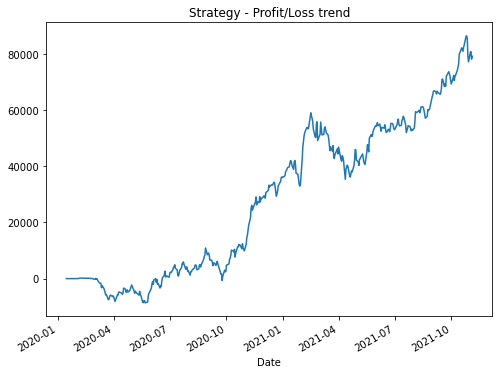

In [495]:
basket6 = strategy_calc(basket6)

In [496]:
basket6, values = strategy_results(basket6)

Total units invested - 378.0 units
Total amount invested - Rs.144379.01
Avg monthly investment - Rs.6277.35
Net absolute returns - 55.00000000000001%
Range of Basket P/L - Rs.-8624.44 - Rs.86394.05


In [497]:
strat = 'double_dips_monthly'
metrics = ['units_invested','total_amount','avg_month_invest','abs_returns','min_pl','max_pl']
basket_strat[strat] = dict(zip(metrics,values))

In [498]:
pd.DataFrame(basket_strat)

,Buy_2units_weekly,Buy_10units_monthly,Buy_rs1500.0_weekly,Buy_rs5000.0_monthly,double_dips_weekly,double_dips_monthly
units_invested,188.00,220.00,294.00,254.00,378.00,378.00
total_amount,81881.48,96252.50,119901.87,105227.13,152434.74,144379.01
avg_month_invest,3560.06,4184.89,5213.12,4575.09,6627.60,6277.35
abs_returns,36.00,35.00,45.00,43.00,47.00,55.00
min_pl,-3011.62,-3390.80,-4826.64,-4059.00,-7395.99,-8624.44
max_pl,32926.26,37974.20,59655.97,49800.53,78418.47,86394.05


By comparison, it is clear that buying weekly and accumulating during dips (less than 50% percentile value) of all time, can create better returns in this basket. With this, we shall keep the strategy as weekly - multiply the dips.

Lets find the best combination of baskets, to get better returns for this strategy.

### Basket analysis

In [591]:
def data_prep(df):
    
    data = df.copy()
    data.drop(['Open','High','Low','Dividends','Stock Splits'],axis=1,inplace=True)
    data['month'] = data.reset_index()['Date'].dt.month.values
    data['week_no'] = data.reset_index()['Date'].dt.isocalendar()['week'].values
    data['weekday'] = data.reset_index()['Date'].dt.isocalendar()['day'].values
    data['year'] = data.reset_index()['Date'].dt.year.values
    data['month_yr'] = data['month'].astype(str) + '_' + data['year'].astype(str)
    data.rename(columns={'Close':'price'},inplace=True)
    volume_75pct = data['Volume'].quantile(0.75)
    print(f"75 percentile of volumes - {volume_75pct}")
    return data, volume_75pct

In [642]:
def strategy_ticker(ticker_name, days,dip_quantile,n_rows,time_frame,week_amount,multiplier,limited_window,amt_constant):
    
    if len(ticker_name) == 1:
        
        ticker = yf.Ticker(ticker_name[0])
        ticker_data = ticker.history(period=days)
        ticker_data,volume_pct = data_prep(ticker_data)
        
    else:
        
        ticker = yf.Ticker(ticker_name[0])
        ticker_data = ticker.history(period=days)
        
        for t in range(1,len(ticker_name)):
            
            ticker = yf.Ticker(ticker_name[t])
            tdata = ticker.history(period=days)
            ticker_data = ticker_data.merge(tdata[['Close','Volume']],left_index=True,right_index=True)
        
        #print(ticker_data.columns)
        close_cols = [x for x in ticker_data.columns if 'Close' in x]
        vol_cols = [x for x in ticker_data.columns if 'Volume' in x]
        
        ticker_data['price'] = ticker_data[close_cols].sum(axis=1)
        ticker_data['vols'] = ticker_data[vol_cols].sum(axis=1)
        
        ticker_data = ticker_data.drop(close_cols,axis=1)
        ticker_data = ticker_data.drop(vol_cols,axis=1)
        
        ticker_data.rename(columns={'price':'Close','vols':'Volume'},inplace=True)
        
        ticker_data,volume_pct = data_prep(ticker_data)
        
    print(ticker_data.price.mean())
    basket = ticker_data.copy()
    basket.reset_index(inplace=True)
    
    
    for r in range(n_rows,len(basket)):
        price_val = basket.loc[r,'price']
        dip_value = basket.iloc[:r,:]['price'].quantile(dip_quantile)
        if price_val < dip_value:
            dips = 1
        else:
            dips = 0

        basket.loc[r,'dips'] = dips
        
    basket.fillna(0,inplace=True)
    basket.set_index('Date',inplace=True)
    
    basket['buy'] = np.where(basket['week_no'].shift(1).bfill() != basket['week_no'],1,0)
    n_units = math.floor(week_amount/basket['price'].mean())
    
    if amt_constant:
        basket['units'] = basket['price'].apply(lambda x: math.floor(week_amount/x))
    else:
        basket['units'] = n_units
    
    basket['buy_units'] = basket['buy'] * basket['units']
    basket['buy_units'] = np.where(basket['dips'] == 1,basket['buy_units']*multiplier,basket['buy_units'])
    basket['buy_price'] = (basket['buy_units'] * basket['price']).round(2)
    max_buy = basket['buy_price'].max()
    
    basket = strategy_calc(basket)
    
    basket, values = strategy_results(basket)
    
    values.append(volume_pct)
    values.append(max_buy)
    values.append(round(dip_value,0))
    
    return basket, values

### ETFs available for investing

In [643]:
nifty = 'NIFTYBEES.NS'
bnifty = 'BANKBEES.NS'
jnifty = 'JUNIORBEES.NS'
hnifty = 'NETFNIF100.NS'
inifty = 'INFRABEES.NS'
cpse = 'CPSEETF.NS'

In [644]:
# Parameters

days = '450d'
dip_quantile = 0.50
n_rows = 31
time_frame = n_rows - 1
week_amount = 1500.0
multiplier = 3
limited_window = False
amt_constant = True

# Create dictionary to append all strategy values for comparison
basket_strat = dict()

metrics = ['units_invested','total_amount','avg_month_invest','abs_returns','min_pl','max_pl',
            '75%_volume','max_buy/sip','dip_cutoff']

In [645]:
tickers = [nifty,bnifty,jnifty,hnifty,inifty,cpse]

NIFTYBEES.NS
75 percentile of volumes - 2265003.0
142.08839667985063
Total units invested - 1374 units
Total amount invested - Rs.170701.89
Avg monthly investment - Rs.7421.82
Net absolute returns - 56.00000000000001%
Range of Basket P/L - Rs.-6080.01 - Rs.102542.56
BANKBEES.NS
75 percentile of volumes - 1130108.0
295.2502675895436
Total units invested - 704 units
Total amount invested - Rs.177508.0
Avg monthly investment - Rs.7717.74
Net absolute returns - 57.99999999999999%
Range of Basket P/L - Rs.-11363.02 - Rs.114350.57
JUNIORBEES.NS
75 percentile of volumes - 108022.0
333.0089980297471
Total units invested - 560 units
Total amount invested - Rs.164730.28
Avg monthly investment - Rs.7162.19
Net absolute returns - 54.0%
Range of Basket P/L - Rs.-5512.32 - Rs.97271.53
NETFNIF100.NS
75 percentile of volumes - 0.0
129.507976778366
Total units invested - 1089 units
Total amount invested - Rs.138958.08
Avg monthly investment - Rs.6041.66
Net absolute returns - 51.0%
Range of Basket P/L 

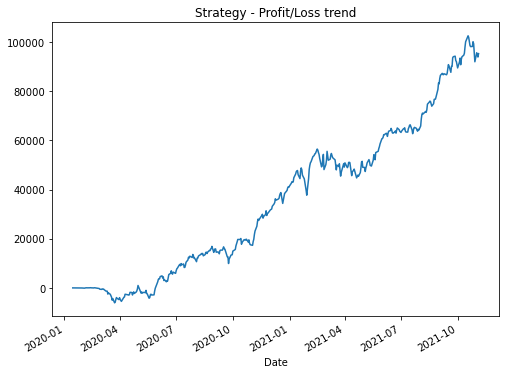

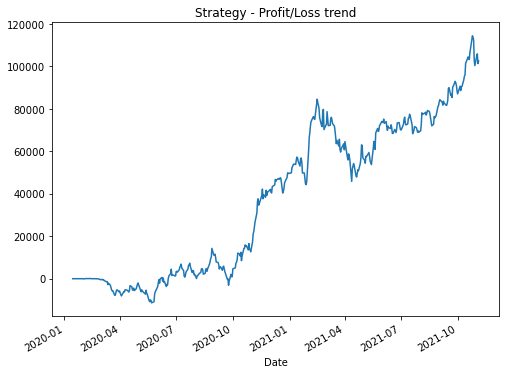

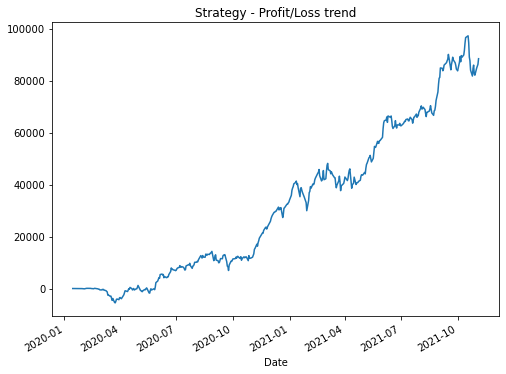

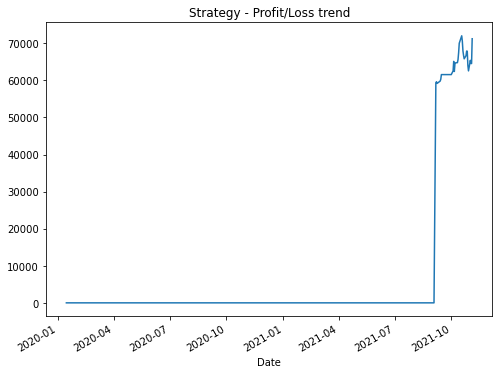

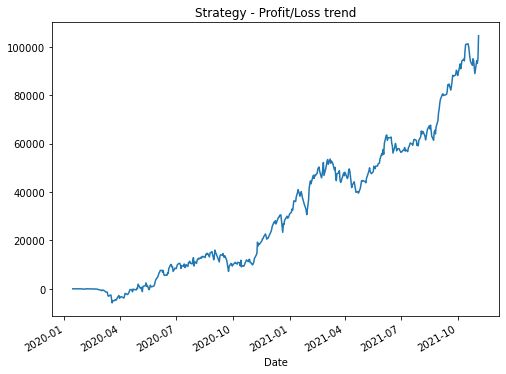

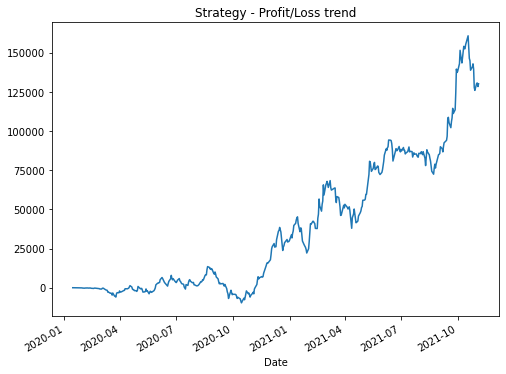

In [646]:
for t in tickers:
    print(t)
    ticker = [t]
    b, values = strategy_ticker(ticker, days,dip_quantile,n_rows,time_frame,week_amount,multiplier,
                                limited_window,amt_constant)
    strategy = f"Invest in {t}"
    basket_strat[strategy] = dict(zip(metrics,values))

In [647]:
pd.DataFrame(basket_strat).T.sort_values(by='abs_returns',ascending=False)

,units_invested,total_amount,avg_month_invest,abs_returns,min_pl,max_pl,75%_volume,max_buy/sip,dip_cutoff
Invest in INFRABEES.NS,476.0,159372.66,6929.25,66.0,-5800.28,104583.63,2255.0,4396.14,371.0
Invest in CPSEETF.NS,11728.0,220739.94,9597.39,59.0,-9654.46,160794.85,5587304.0,4498.80,20.0
Invest in BANKBEES.NS,704.0,177508.00,7717.74,58.0,-11363.02,114350.57,1130108.0,4465.02,314.0
Invest in NIFTYBEES.NS,1374.0,170701.89,7421.82,56.0,-6080.01,102542.56,2265003.0,4446.00,143.0
Invest in JUNIORBEES.NS,560.0,164730.28,7162.19,54.0,-5512.32,97271.53,108022.0,4445.28,330.0
Invest in NETFNIF100.NS,1089.0,138958.08,6041.66,51.0,0.00,72033.93,0.0,1496.32,124.0


### Basket - Combination of 2 ETFs

In [648]:
from itertools import combinations

baskets = list(combinations(tickers,2))

In [649]:
# Create dictionary to append all strategy values for comparison
basket_strat = dict()

('NIFTYBEES.NS', 'BANKBEES.NS')
75 percentile of volumes - 3701663.0
437.3386642693942
Total units invested - 434 units
Total amount invested - Rs.162286.89
Avg monthly investment - Rs.7055.95
Net absolute returns - 57.99999999999999%
Range of Basket P/L - Rs.-8323.62 - Rs.102789.95
('NIFTYBEES.NS', 'JUNIORBEES.NS')
75 percentile of volumes - 2400116.0
475.0973947095977
Total units invested - 359 units
Total amount invested - Rs.149734.99
Avg monthly investment - Rs.6510.22
Net absolute returns - 55.00000000000001%
Range of Basket P/L - Rs.-4968.54 - Rs.89615.17
('NIFTYBEES.NS', 'NETFNIF100.NS')
75 percentile of volumes - 2265003.0
271.5963734582166
Total units invested - 650 units
Total amount invested - Rs.165174.22
Avg monthly investment - Rs.7181.49
Net absolute returns - 52.0%
Range of Basket P/L - Rs.-2872.32 - Rs.90042.06
('NIFTYBEES.NS', 'INFRABEES.NS')
75 percentile of volumes - 2279636.0
523.753675125224
Total units invested - 339 units
Total amount invested - Rs.155921.25
Av

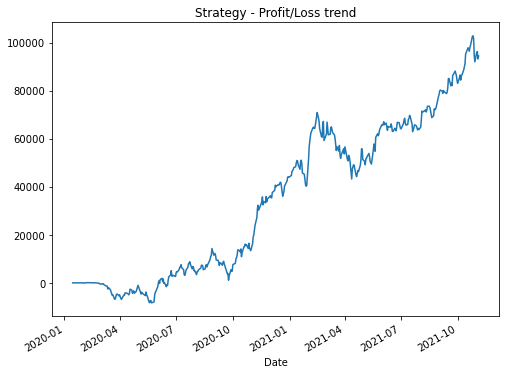

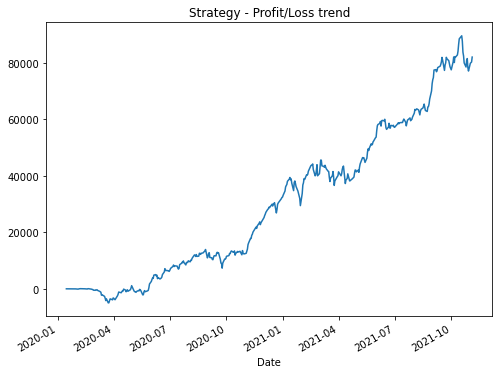

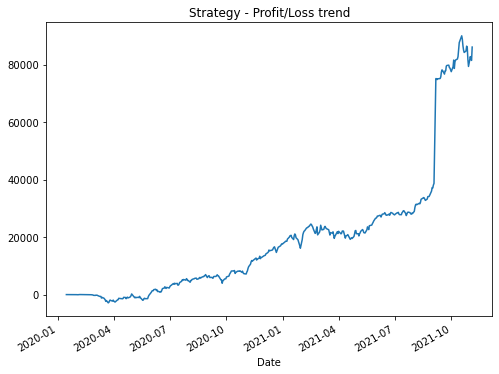

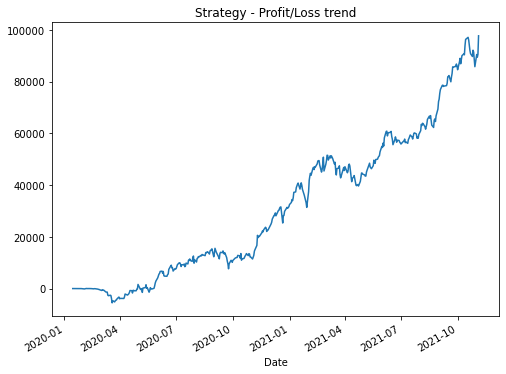

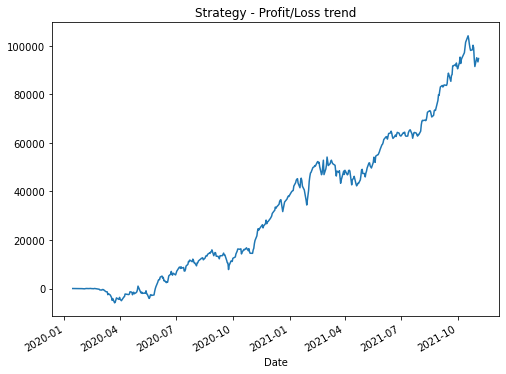

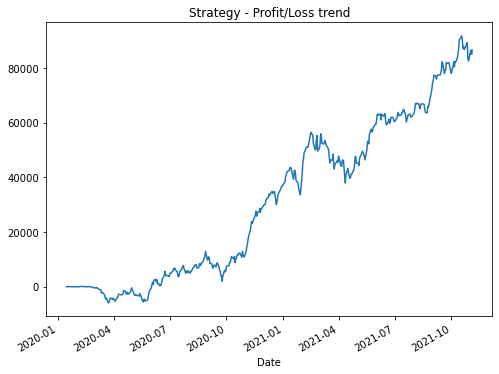

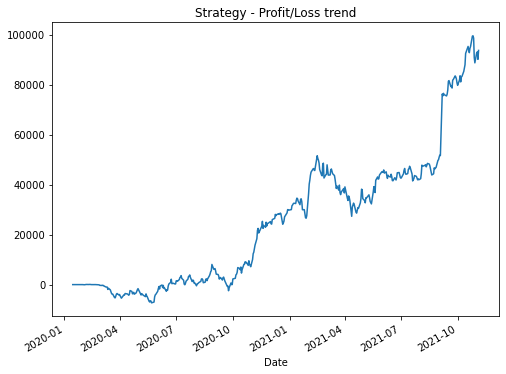

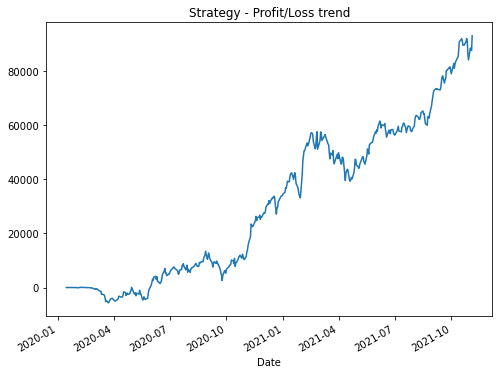

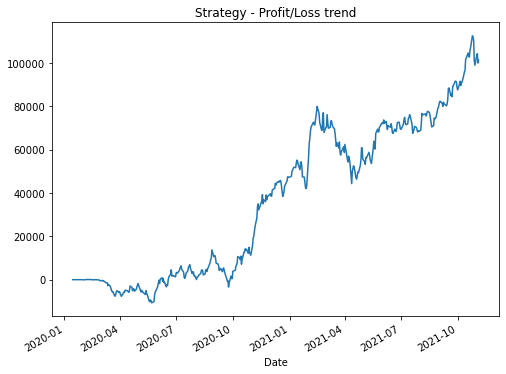

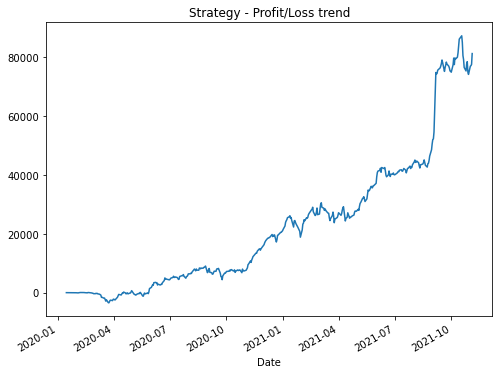

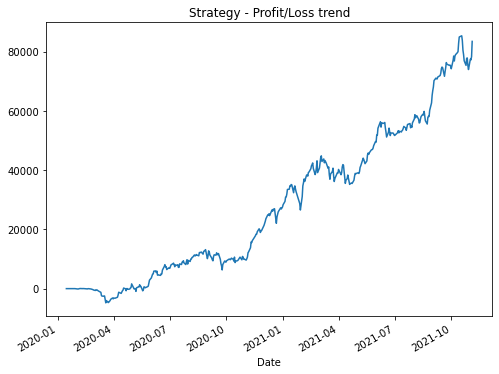

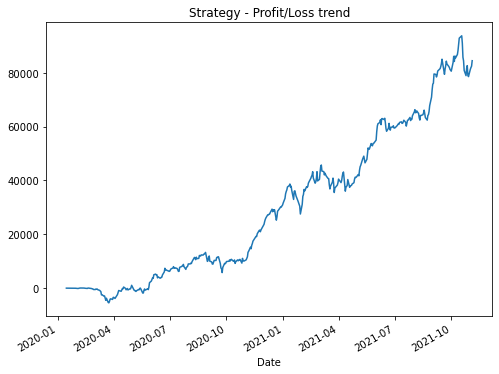

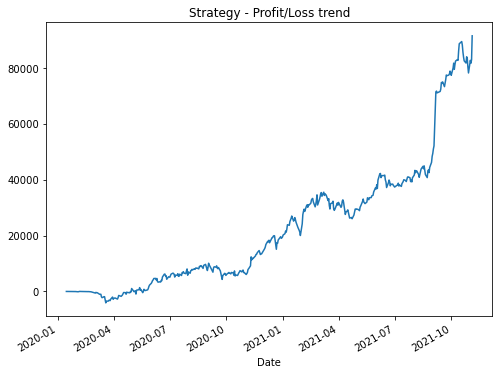

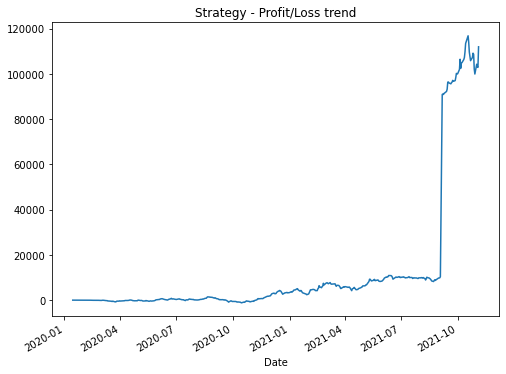

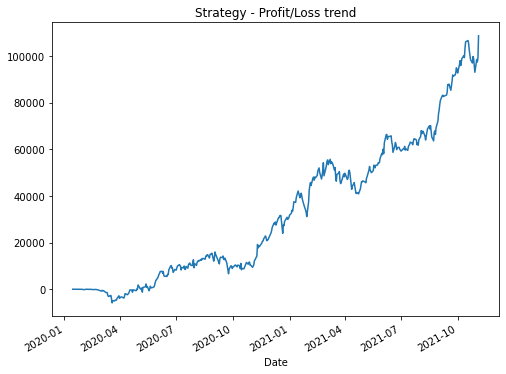

In [650]:
for t in baskets:
    print(t)
    ticker = t
    b, values = strategy_ticker(ticker, days,dip_quantile,n_rows,time_frame,week_amount,multiplier,limited_window,amt_constant)
    strategy = f"Invest in {t}"
    basket_strat[strategy] = dict(zip(metrics,values))

In [651]:
pd.DataFrame(basket_strat).T.sort_values(by='abs_returns',ascending=False)

,units_invested,total_amount,avg_month_invest,abs_returns,min_pl,max_pl,75%_volume,max_buy/sip,dip_cutoff
"Invest in ('BANKBEES.NS', 'INFRABEES.NS')",248.0,143103.99,6221.91,65.0,-5670.00,93046.58,1131206.0,4309.65,670.0
"Invest in ('INFRABEES.NS', 'CPSEETF.NS')",471.0,166600.93,7243.52,65.0,-5832.21,108675.03,5590388.0,4456.80,391.0
"Invest in ('NIFTYBEES.NS', 'INFRABEES.NS')",339.0,155921.25,6779.18,63.0,-5519.22,97691.44,2279636.0,4485.48,515.0
"Invest in ('JUNIORBEES.NS', 'INFRABEES.NS')",215.0,132992.16,5782.27,63.0,-4797.48,85329.45,110059.0,4465.26,701.0
"Invest in ('NETFNIF100.NS', 'INFRABEES.NS')",326.0,152263.77,6620.16,60.0,-4076.70,91437.54,2517.0,4414.68,494.0
"Invest in ('BANKBEES.NS', 'CPSEETF.NS')",639.0,172130.42,7483.93,59.0,-10695.29,112487.65,6434493.0,4476.78,334.0
"Invest in ('NIFTYBEES.NS', 'BANKBEES.NS')",434.0,162286.89,7055.95,58.0,-8323.62,102789.95,3701663.0,4470.00,450.0
"Invest in ('BANKBEES.NS', 'JUNIORBEES.NS')",280.0,151341.36,6580.06,57.0,-5926.72,91808.75,1256935.0,4464.45,632.0
"Invest in ('NIFTYBEES.NS', 'JUNIORBEES.NS')",359.0,149734.99,6510.22,55.0,-4968.54,89615.17,2400116.0,4259.10,473.0
"Invest in ('NIFTYBEES.NS', 'CPSEETF.NS')",1188.0,170769.33,7424.75,55.0,-5899.22,104129.73,7863539.0,4492.41,163.0


### Basket - Combination of 3 ETFs

In [652]:
baskets = list(combinations(tickers,3))

In [653]:
# Create dictionary to append all strategy values for comparison
basket_strat = dict()

('NIFTYBEES.NS', 'BANKBEES.NS', 'JUNIORBEES.NS')
75 percentile of volumes - 3822593.0
770.3476622991413
Total units invested - 201 units
Total amount invested - Rs.133562.18
Avg monthly investment - Rs.5807.05
Net absolute returns - 56.99999999999999%
Range of Basket P/L - Rs.-6590.76 - Rs.80947.48
('NIFTYBEES.NS', 'BANKBEES.NS', 'NETFNIF100.NS')
75 percentile of volumes - 3701663.0
566.8466410477602
Total units invested - 308 units
Total amount invested - Rs.156248.88
Avg monthly investment - Rs.6793.43
Net absolute returns - 55.00000000000001%
Range of Basket P/L - Rs.-5600.95 - Rs.90391.49
('NIFTYBEES.NS', 'BANKBEES.NS', 'INFRABEES.NS')
75 percentile of volumes - 3714675.0
819.0039427147676
Total units invested - 190 units
Total amount invested - Rs.133979.33
Avg monthly investment - Rs.5825.19
Net absolute returns - 62.0%
Range of Basket P/L - Rs.-4946.53 - Rs.83925.47
('NIFTYBEES.NS', 'BANKBEES.NS', 'CPSEETF.NS')
75 percentile of volumes - 8654103.0
458.63494489240753
Total units 

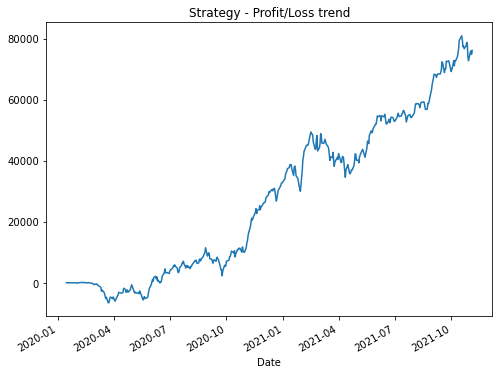

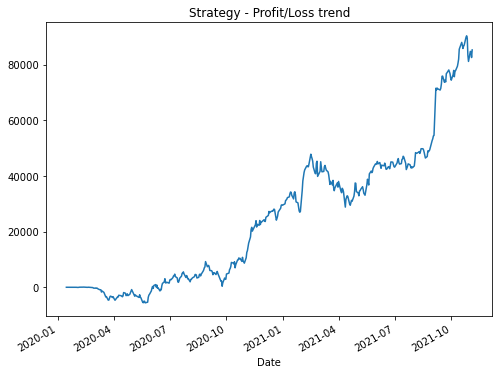

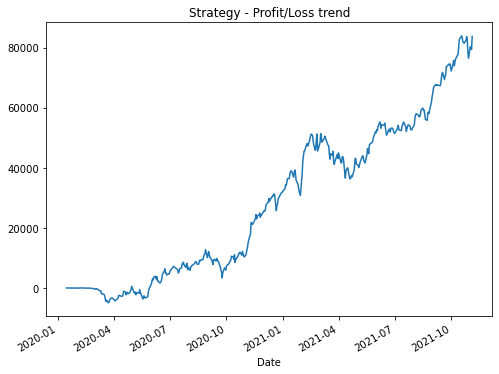

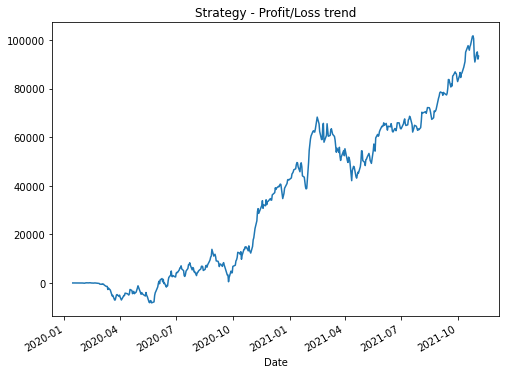

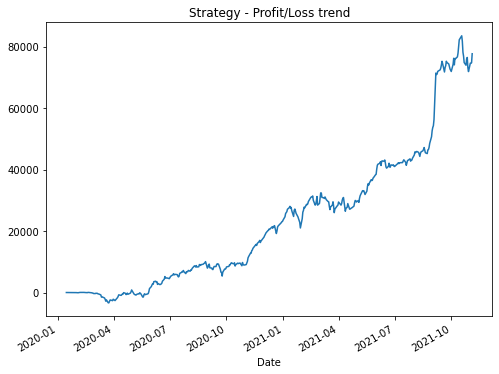

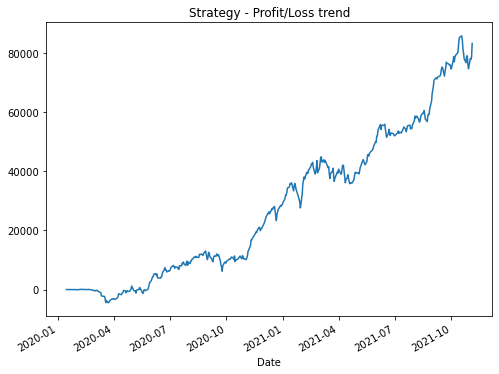

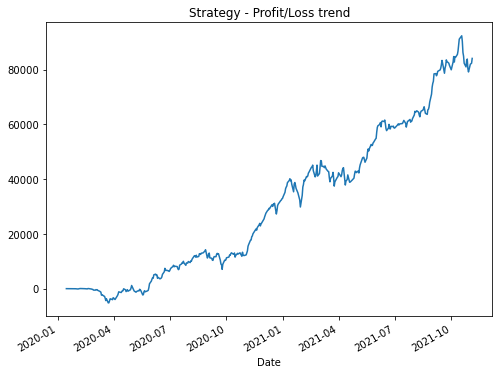

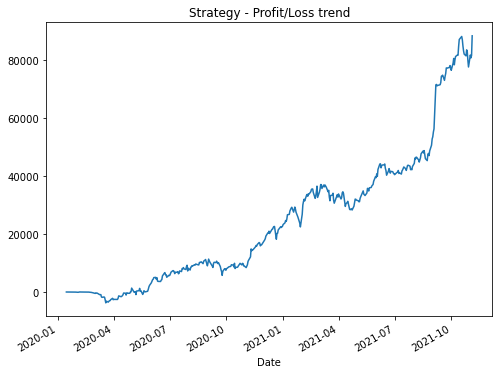

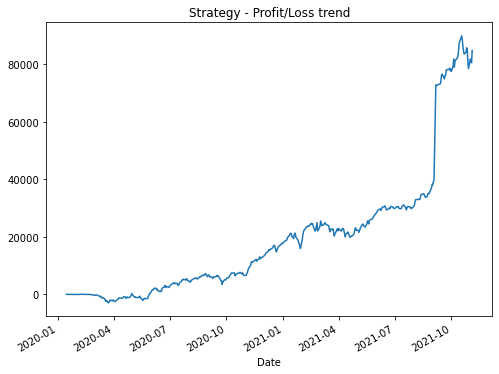

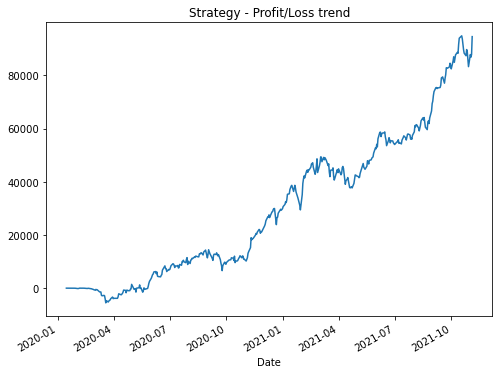

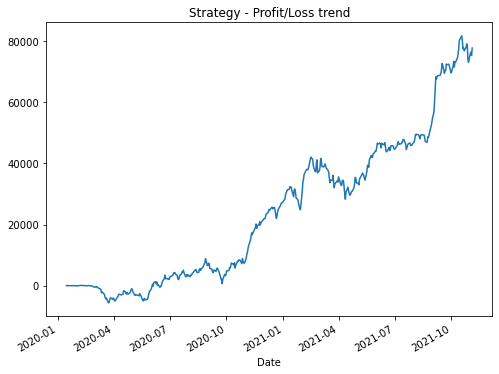

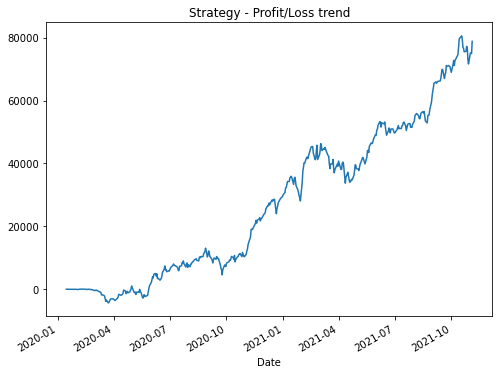

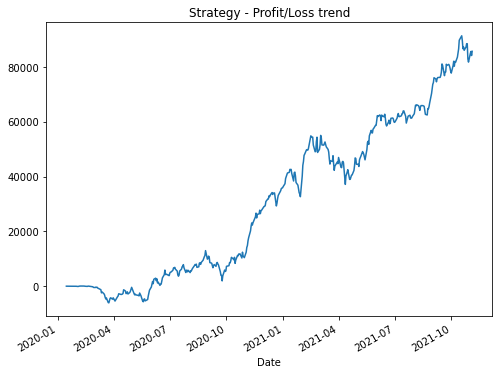

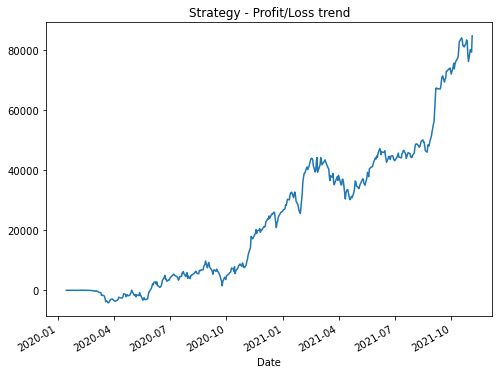

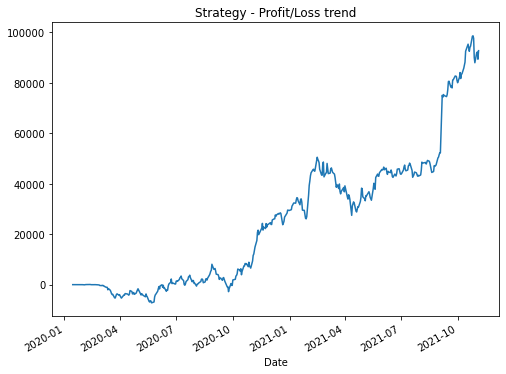

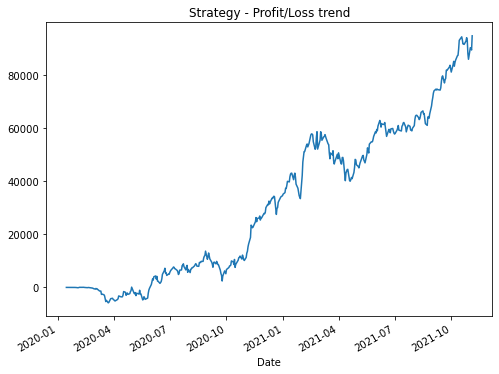

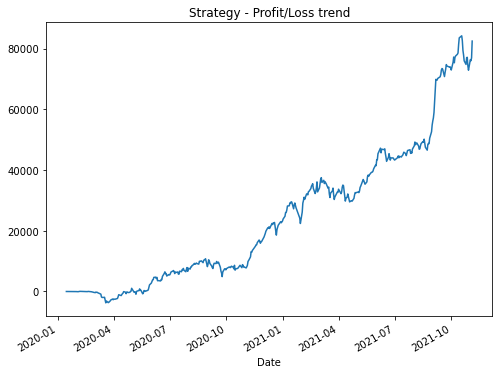

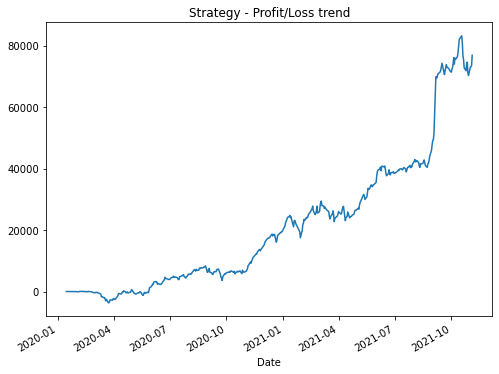

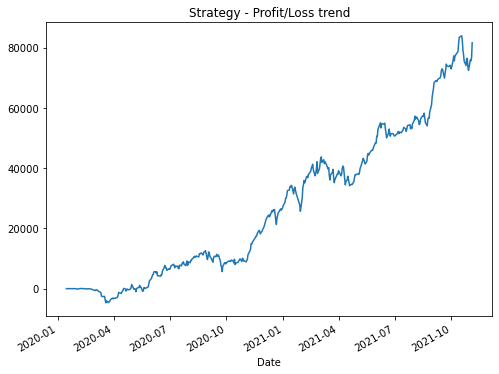

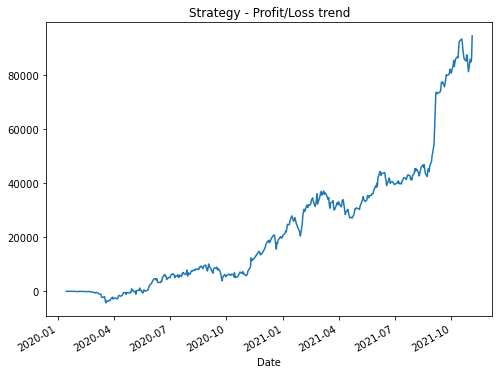

In [654]:
for t in baskets:
    print(t)
    ticker = t
    b, values = strategy_ticker(ticker, days,dip_quantile,n_rows,time_frame,week_amount,multiplier,limited_window,amt_constant)
    strategy = f"Invest in {t}"
    basket_strat[strategy] = dict(zip(metrics,values))

In [655]:
pd.DataFrame(basket_strat).T.sort_values(by='abs_returns',ascending=False)

,units_invested,total_amount,avg_month_invest,abs_returns,min_pl,max_pl,75%_volume,max_buy/sip,dip_cutoff
"Invest in ('BANKBEES.NS', 'INFRABEES.NS', 'CPSEETF.NS')",244.0,144942.24,6301.84,65.0,-5810.36,94699.93,6435646.0,4464.45,694.0
"Invest in ('NIFTYBEES.NS', 'BANKBEES.NS', 'INFRABEES.NS')",190.0,133979.33,5825.19,62.0,-4946.53,83925.47,3714675.0,4389.30,814.0
"Invest in ('JUNIORBEES.NS', 'INFRABEES.NS', 'CPSEETF.NS')",205.0,130938.15,5692.96,62.0,-4714.64,83893.51,5693296.0,4392.54,721.0
"Invest in ('NIFTYBEES.NS', 'INFRABEES.NS', 'CPSEETF.NS')",317.0,152055.08,6611.09,62.0,-5521.44,94895.58,7875080.0,4429.20,535.0
"Invest in ('NETFNIF100.NS', 'INFRABEES.NS', 'CPSEETF.NS')",322.0,155871.58,6777.03,61.0,-4262.94,94473.77,5590388.0,4404.84,514.0
"Invest in ('NIFTYBEES.NS', 'JUNIORBEES.NS', 'INFRABEES.NS')",184.0,137577.81,5981.64,61.0,-4508.15,85843.93,2400762.0,4197.84,845.0
"Invest in ('NIFTYBEES.NS', 'NETFNIF100.NS', 'INFRABEES.NS')",249.0,145950.21,6345.66,61.0,-3740.82,88393.66,2279636.0,4477.05,639.0
"Invest in ('BANKBEES.NS', 'NETFNIF100.NS', 'INFRABEES.NS')",195.0,138563.16,6024.49,61.0,-4192.32,84758.65,1131206.0,4341.12,794.0
"Invest in ('JUNIORBEES.NS', 'NETFNIF100.NS', 'INFRABEES.NS')",184.0,138240.70,6010.47,60.0,-3740.51,84241.61,110059.0,4229.46,825.0
"Invest in ('NIFTYBEES.NS', 'BANKBEES.NS', 'CPSEETF.NS')",409.0,160771.75,6990.08,58.0,-8185.08,101714.81,8654103.0,4443.30,471.0
